# FYS-STK 4155 H20 PROJECT 1

## Definitions

In [89]:
np.random.seed(1)

In [90]:
# From the assignment; The function that we are goint to approximate
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [91]:
# Generate samples from the FrankeFunction with some optional noise
def franke_sampler(x, y, noise=.1):
    f = FrankeFunction(x, y).reshape(len(x), 1)
    var_eps = noise * np.var(f)
    z = f + np.sqrt(var_eps)*np.random.randn(len(x), 1)
    return (z, f, var_eps)

In [92]:
# Create a mesh with sn uniform randomly scattered points in the rectangle (x_start, y_start), (x_end, y_end). Returned ndarrays have shape (sn, 1)
def randmesh(sn=100, x_start=0., y_start=0., x_end=1., y_end=1.):
    x = np.random.uniform(x_start, x_end, (sn, 1))
    y = np.random.uniform(y_start, y_end, (sn, 1))
    return (x, y)

In [93]:
# Make design matrix with polinomial degree np in two variables
def make_design_matrix(x, y, pn=5):
    X = np.ndarray([len(x), int((pn+1)*(pn+2)/2)])

    ex = [0]*int((pn+1)*(pn+2)/2)
    ey = [0]*int((pn+1)*(pn+2)/2)
    kx = ky = 0
    for i in range(pn+1):
        for j in range(i+1):
            ex[kx] = j
            kx += 1
        for j in range(i,-1,-1):
            ey[ky] = j
            ky += 1

    for i, (xi, yi) in enumerate(zip(x, y)):
        X[i,:] = [(xi**px)*(yi**py) for px, py in zip(ex, ey)]
    
    return X

In [94]:
# Defining some useful functions
def mse(y, y_tilde):
    return np.mean(np.mean((y - y_tilde)**2, axis=1, keepdims=True))

def r2(y, y_tilde):
    return 1 - sum((y - y_tilde)**2)/sum((y - np.mean(y, axis=1, keepdims=True))**2)

def bias(f, y_tilde):
    return np.mean((f - np.mean(y_tilde, axis=1, keepdims=True))**2)

def var(y):
    return np.mean(np.var(y, axis=1, keepdims=True))

def preprocess(X, z, f, train_size=.7):
    X_train, X_test, z_train, z_test, f_train, f_test = skl.model_selection.train_test_split(X, z, f, train_size=.7, random_state=0)
    scaler = skl.preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return (X_train, X_test, z_train, z_test, f_train, f_test)

In [95]:
x, y = randmesh(sn=1000)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=.05)
max_pol_order = 20
bootstraps = 100

In [96]:
mse_df = DataFrame()
mse_df["pol order"] = list(range(max_pol_order+1))
mse_df["mse train"] = np.ndarray(max_pol_order+1)
mse_df["mse test"] = np.ndarray(max_pol_order+1)

for pn in mse_df["pol order"]:
    X = make_design_matrix(x, y, pn=pn)
    X_train, X_test, z_train, z_test, f_train, f_test = preprocess(X, z, f, train_size=.7)
    
    beta_hat = np.linalg.pinv(X_train) @ z_train
    z_train_tilde = X_train @ beta_hat
    z_test_tilde = X_test @ beta_hat
    
    mse_df.at[pn, "mse train"] = mse(z_train, z_train_tilde)
    mse_df.at[pn, "mse test"] = mse(z_test, z_test_tilde)

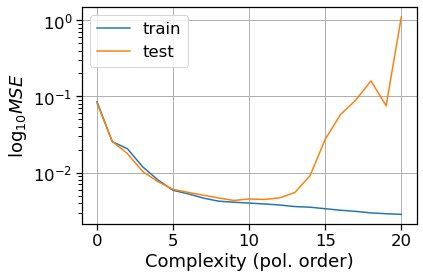

In [97]:
ax = mse_df.plot(x="pol order", logy=True)
ax.legend(["train", "test"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("$\log_{10} MSE$")
ax.grid(True)
plt.show()

In [98]:
#fig, ax = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(15,7))
#mse_df.plot(ax=ax[0], x="pol order", y=["MSE train", "MSE test"], logy=True)
#mse_df.plot(ax=ax[1], x="pol order", y=["MSE test", "bias", "var"], logy=False)
#ax[0].legend(["train", "test"])
#ax[0].set_ylabel("$\log_{10} MSE$")
#ax[0].grid(True)
#ax[1].grid(True)
#fig.text(.5, .04, "Complexity (polynomial order)", ha="center")
#plt.show()

In [113]:
bivar_df = DataFrame()
bivar_df["pol order"] = list(range(max_pol_order+1))
bivar_df["mse"] = np.ndarray(max_pol_order+1)
bivar_df["bias"] = np.ndarray(max_pol_order+1)
bivar_df["var"] = np.ndarray(max_pol_order+1)

for pn in mse_df["pol order"]:
    X = make_design_matrix(x, y, pn=pn)
    X_train, X_test, z_train, z_test, f_train, f_test = preprocess(X, z, f, train_size=.7)
    z_test_tilde = np.ndarray((len(z_test), bootstraps))
    
    for bs in range(bootstraps):
        X_train_resampled, z_train_resampled = skl.utils.resample(X_train, z_train, random_state=bs)
        beta_hat = np.linalg.pinv(X_train_resampled) @ z_train_resampled
        z_test_tilde[:, bs] = (X_test @ beta_hat).ravel()
    
    bivar_df.at[pn, "mse"] = mse(z_test, z_test_tilde)
    bivar_df.at[pn, "bias"] = bias(f_test, z_test_tilde)
    bivar_df.at[pn, "var"] = var(z_test_tilde)

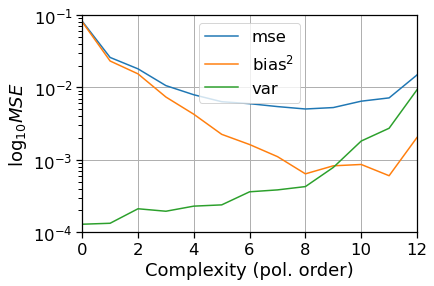

In [124]:
ax = bivar_df.plot(x="pol order", logy=True)
ax.legend(["mse", "bias$^2$", "var"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("$\log_{10} MSE$")
ax.set_xlim(0,12)
ax.set_ylim(.0001, .1)
ax.grid(True)
plt.show()